In [283]:
from pathlib import Path
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from knee_stress_predict.config import processed_data_dir
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

## Load data

In [172]:
data_set_name = "set_3"
train_file_path = Path.joinpath(processed_data_dir, data_set_name,  "train_cleaned.csv")
test_file_path = Path.joinpath(processed_data_dir, data_set_name,  "test_cleaned.csv")
train_data = pd.read_csv(train_file_path).drop('Unnamed: 0', axis=1)
test_data = pd.read_csv(test_file_path).drop('Unnamed: 0', axis=1)

In [173]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32776 entries, 0 to 32775
Data columns (total 53 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Code                           32776 non-null  object 
 1   Patella_PN                     32776 non-null  int64  
 2   Femur_PN                       32776 non-null  int64  
 3   Tibia_PN                       32776 non-null  int64  
 4   Patella_Car_PN                 32776 non-null  int64  
 5   Femur_Car_PN                   32776 non-null  int64  
 6   Tibia_M_Car_PN                 32776 non-null  int64  
 7   Tibia_L_Car_PN                 32776 non-null  int64  
 8   Patella_volume                 32776 non-null  float64
 9   Femur_volume                   32776 non-null  float64
 10  Tibia_volume                   32776 non-null  float64
 11  Patella_Car_volume             32776 non-null  float64
 12  Femur_Car_volume               32776 non-null 

In [174]:
def get_tframe_dataset(tframe_num, dataset):
    tframe_dataset = dataset[dataset['frame'] == tframe_num]
    return tframe_dataset

In [175]:
train_datasets = get_tframe_dataset(0, train_data)
test_datasets = get_tframe_dataset(0, test_data)

## Drop unnecessary columns

We need to delete "Max_tib_med_contact_pressure" and "Max_tib_lat_contact_pressure" since these features are for 0-time points only. In this notebook, we are more concentrated on maximal contact pressure, which are: "med_Max_all_frames" and "lat_Max_all_frames"

In [176]:
train_datasets = train_datasets.drop(["frame", "Code", "Max_tib_med_contact_pressure", "Max_tib_lat_contact_pressure"], axis=1)

test_datasets = test_datasets.drop(["frame", "Code", "Max_tib_med_contact_pressure", "Max_tib_lat_contact_pressure"], axis=1)

In [177]:
train_datasets

,Patella_PN,Femur_PN,Tibia_PN,Patella_Car_PN,Femur_Car_PN,Tibia_M_Car_PN,Tibia_L_Car_PN,Patella_volume,Femur_volume,Tibia_volume,...,tib_lat_ishealthy,femur_gap_dist,Max_dist_femur_tibia_lat_car,Min_dist_femur_tibia_lat_car,Mean_dist_femur_tibia_lat_car,Max_dist_femur_tibia_med_car,Min_dist_femur_tibia_med_car,Mean_dist_femur_tibia_med_car,lat_Max_all_frames,med_Max_all_frames
0,1126,4113,2684,5900,21030,2840,2840,33039.218053,228671.171460,134963.134980,...,1,22.935425,13.560157,0.800195,6.226970,10.677269,1.029139,4.306716,20.057634,31.649405
241,771,3414,2596,4485,18385,2840,2840,21736.919532,184294.924991,127637.611277,...,1,19.539911,12.892850,1.504442,4.844820,9.243396,1.418712,4.015682,18.555532,26.223894
482,730,3404,2600,5055,18755,2840,2840,20866.993760,184114.045604,128295.783408,...,1,18.387004,11.617199,1.119438,4.698536,9.107268,1.398252,3.890993,19.447876,24.808067
723,667,3814,2631,5245,19370,2840,2840,17949.168458,221202.458278,137472.394625,...,1,19.128202,12.324972,2.210197,6.003760,10.941657,2.428147,5.948101,19.930437,25.919180
964,971,3746,2799,4985,22785,2840,2840,30455.804840,217672.765536,155360.366258,...,1,22.098599,16.570434,1.646447,5.989795,11.721987,1.394432,4.899639,26.539942,14.729120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31571,633,3084,2205,4255,20260,2185,2840,15168.028148,146698.667898,102326.881891,...,1,21.102991,14.732158,1.686715,5.659945,13.039994,1.308433,4.848711,20.220541,36.707184
31812,686,2963,2388,4405,20910,2155,2840,15821.015946,140615.628188,110523.109264,...,1,19.857552,18.010511,1.444001,5.899954,13.425811,1.667098,5.354239,27.401314,34.442417
32053,795,3669,2724,4765,20410,2840,2840,22375.020348,207318.185631,146786.471170,...,1,22.148186,16.633343,1.874496,6.641354,15.426130,2.258161,4.898385,19.478767,22.278835
32294,801,3805,2575,4885,20400,2840,2840,22439.863013,215968.865103,136753.285023,...,1,22.762806,17.640301,1.481010,6.875417,12.561378,2.246910,4.471387,20.616781,26.929873


In [178]:
test_datasets

,Patella_PN,Femur_PN,Tibia_PN,Patella_Car_PN,Femur_Car_PN,Tibia_M_Car_PN,Tibia_L_Car_PN,Patella_volume,Femur_volume,Tibia_volume,...,tib_lat_ishealthy,femur_gap_dist,Max_dist_femur_tibia_lat_car,Min_dist_femur_tibia_lat_car,Mean_dist_femur_tibia_lat_car,Max_dist_femur_tibia_med_car,Min_dist_femur_tibia_med_car,Mean_dist_femur_tibia_med_car,lat_Max_all_frames,med_Max_all_frames
0,539,3078,2148,4425,18345,2840,2840,13217.352901,157049.737203,106526.281429,...,1,14.423590,14.321398,1.585903,5.646224,8.844857,1.074716,4.018044,20.898586,27.309856
241,540,3022,2184,4285,16095,2840,2840,14288.702996,159086.371584,107813.929805,...,1,16.590023,13.103768,1.331985,4.745842,8.821852,0.469025,3.081904,27.334072,33.981598
482,632,3265,2300,4615,19715,2840,2840,16215.273244,174308.699962,113090.275314,...,1,17.502411,13.700978,1.615834,4.960033,10.516684,0.908140,4.071796,20.869864,22.966322
723,869,3581,3042,4875,20620,2840,2840,26373.133976,201525.181237,172656.815701,...,1,19.041824,18.442018,2.367709,7.102561,15.291503,2.578706,6.441420,19.721767,21.458328
964,922,3866,2738,4645,21800,2340,2840,26822.466759,217761.486440,143150.197170,...,1,24.568038,22.752636,1.440737,7.901696,17.943346,0.774024,5.269343,21.266918,26.806919
1205,997,3569,3013,5035,22675,2840,2840,31601.733987,206925.519779,168725.205892,...,1,19.937188,16.729068,1.207820,6.030796,10.350523,0.664740,4.025312,24.263035,16.543530
1446,580,2726,2223,4575,20165,2840,2840,13901.490578,129091.525824,102711.476797,...,1,17.791252,18.501297,1.912809,6.434524,14.265063,1.038996,4.600930,24.354988,31.521906
1687,704,3589,2680,5735,19095,2840,2840,19181.692461,197000.659506,145652.581038,...,1,18.845673,14.280392,2.602943,6.476641,9.661562,1.733849,4.836324,22.124178,29.335966
1928,639,2942,2069,1605,14805,2840,2840,15908.433842,149242.250217,99087.964847,...,1,16.251732,12.877489,1.427210,5.348188,9.862777,1.474976,4.303591,18.513151,23.035765
2169,706,3320,2170,3360,20680,4260,2840,18799.562749,164129.999650,97898.558255,...,1,44.107787,10.271868,1.303613,4.619040,9.772798,1.245017,3.984866,23.169041,22.456438


(array([ 1.,  0.,  5., 11., 14., 23., 16., 12., 18., 11.,  5.,  4.,  5.,
         4.,  0.,  2.,  1.,  0.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([10.92055035, 12.53574152, 14.15093269, 15.76612387, 17.38131504,
        18.99650621, 20.61169739, 22.22688856, 23.84207973, 25.45727091,
        27.07246208, 28.68765326, 30.30284443, 31.9180356 , 33.53322678,
        35.14841795, 36.76360912, 38.3788003 , 39.99399147, 41.60918264,
        43.22437382, 44.83956499, 46.45475616, 48.06994734, 49.68513851,
        51.30032969, 52.91552086, 54.53071203, 56.14590321, 57.76109438,
        59.37628555]),
 <BarContainer object of 30 artists>)

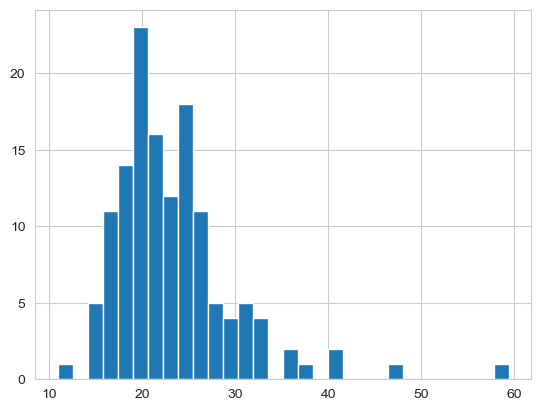

In [179]:
plt.hist(train_datasets[['lat_Max_all_frames']], bins = 30)

## MSE Naive Benchmark

In [180]:
predicted_pressure_med = np.mean(train_datasets[['med_Max_all_frames']])
predicted_pressure_lat = np.mean(train_datasets[['lat_Max_all_frames']])
print(f"Average medial cartilage pressure: {predicted_pressure_med}")
print(f"Average lateral cartilage pressure: {predicted_pressure_lat}")

n = len(test_datasets[['lat_Max_all_frames']])

simple_prediction_med = [predicted_pressure_med for i in range(n)]
simple_prediction_lat = [predicted_pressure_lat for i in range(n)]


Average medial cartilage pressure: med_Max_all_frames    29.015095
dtype: float64
Average lateral cartilage pressure: lat_Max_all_frames    23.286776
dtype: float64


### Metrics for naive prediction

In [303]:
# The mean squared error
mse_mean_med = mean_squared_error(simple_prediction_med, test_datasets[['med_Max_all_frames']])

mse_mean_lat = mean_squared_error(simple_prediction_lat, test_datasets[['lat_Max_all_frames']])

print("Mean squared error medial: %.2f" % mse_mean_med)
print("Mean squared error lateral: %.2f" % mse_mean_lat)

Mean squared error medial: 41.01
Mean squared error lateral: 22.82


## Logistic Regression
### Choose some features

#### Train data set

In [182]:
train_x_LR = train_datasets[["Femur_volume", "Tibia_volume", "Femur_Car_volume",
                                "Tibia_L_Car_volume", "Tibia_L_Car_volume",
                                "Femur_bounds_x", "Tibia_bounds_x",
                                "Femur_Car_bounds_x",
                                "Tibia_M_Car_bounds_x", "Tibia_L_Car_bounds_x",
                                "Femur_bounds_y", "Tibia_bounds_y",
                                "Femur_Car_bounds_y",
                                "Tibia_M_Car_bounds_y", "Tibia_L_Car_bounds_y",
                                "Femur_bounds_z", "Tibia_bounds_z",
                                "Femur_Car_bounds_z",
                                "Tibia_M_Car_bounds_z", "Tibia_L_Car_bounds_z",
                                "Simulation_len",
                                "tib_med_curv", "tib_lat_curv",
                                "tib_med_ishealthy", "tib_lat_ishealthy",
                                "femur_gap_dist",
                                "Mean_dist_femur_tibia_lat_car", "Mean_dist_femur_tibia_med_car"]]

In [183]:
train_y_lat_LR = train_datasets[['lat_Max_all_frames']]
train_y_med_LR = train_datasets[['med_Max_all_frames']]

#### Test data set

In [184]:
test_x_LR = test_datasets[["Femur_volume", "Tibia_volume", "Femur_Car_volume",
                                "Tibia_L_Car_volume", "Tibia_L_Car_volume",
                                "Femur_bounds_x", "Tibia_bounds_x",
                                "Femur_Car_bounds_x",
                                "Tibia_M_Car_bounds_x", "Tibia_L_Car_bounds_x",
                                "Femur_bounds_y", "Tibia_bounds_y",
                                "Femur_Car_bounds_y",
                                "Tibia_M_Car_bounds_y", "Tibia_L_Car_bounds_y",
                                "Femur_bounds_z", "Tibia_bounds_z",
                                "Femur_Car_bounds_z",
                                "Tibia_M_Car_bounds_z", "Tibia_L_Car_bounds_z",
                                "Simulation_len",
                                "tib_med_curv", "tib_lat_curv",
                                "tib_med_ishealthy", "tib_lat_ishealthy",
                                "femur_gap_dist",
                                "Mean_dist_femur_tibia_lat_car", "Mean_dist_femur_tibia_med_car"]]

In [185]:
test_y_lat_LR = test_datasets[['lat_Max_all_frames']]
test_y_med_LR = test_datasets[['med_Max_all_frames']]

### Train LR model

In [186]:
# define the model
# Create linear regression object
regr_lat = linear_model.LinearRegression()
regr_med = linear_model.LinearRegression()

# Train the model using the training sets
regr_lat.fit(train_x_LR, train_y_lat_LR)
regr_med.fit(train_x_LR, train_y_med_LR)

LinearRegression()

### Verify results

In [279]:
# Make predictions using the testing set
test_y_med_LR_pred = regr_med.predict(test_x_LR)
test_y_lat_LR_pred = regr_lat.predict(test_x_LR)

In [280]:
mse_LR_med = mean_squared_error(test_y_med_LR_pred, test_y_med_LR)
mse_LR_lat = mean_squared_error(test_y_lat_LR_pred, test_y_lat_LR)

# The mean squared error
print("Mean squared error medial: %.2f" % mse_LR_med)
print("Mean squared error lateral: %.2f" % mse_LR_lat)

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination medial: %.2f" % r2_score(test_y_med_LR_pred, test_y_med_LR))
print("Coefficient of determination lateral: %.2f" % r2_score(test_y_lat_LR_pred, test_y_lat_LR))

Mean squared error medial: 47.60
Mean squared error lateral: 35.03
Coefficient of determination medial: -0.85
Coefficient of determination lateral: -0.87


## Regularized Regression

In [189]:
train_x = train_datasets.drop(['lat_Max_all_frames', 'med_Max_all_frames'], axis=1)
test_x = test_datasets.drop(['lat_Max_all_frames', 'med_Max_all_frames'], axis=1)

In [190]:
train_y_lat = train_datasets[['lat_Max_all_frames']]
train_y_med = train_datasets[['med_Max_all_frames']]

test_y_lat = test_datasets[['lat_Max_all_frames']]
test_y_med = test_datasets[['med_Max_all_frames']]

### Lasso

In [191]:
model_lasso_lat = linear_model.Lasso(alpha=100, max_iter=1000000)
model_lasso_lat.fit(train_x, train_y_lat)

Lasso(alpha=100, max_iter=1000000)

In [192]:
model_lasso_med = linear_model.Lasso(alpha=100, max_iter=1000000)
model_lasso_med.fit(train_x, train_y_med)

Lasso(alpha=100, max_iter=1000000)

In [197]:
test_y_lat_lasso_predict = model_lasso_lat.predict(test_x)
test_y_mrd_lasso_predict = model_lasso_med.predict(test_x)

In [282]:
mse_lasso_med = mean_squared_error(test_y_med, test_y_mrd_lasso_predict)
mse_lasso_lat = mean_squared_error(test_y_lat, test_y_lat_lasso_predict )
# The mean squared error
print("Mean squared error medial: %.2f" % mse_lasso_med)
print("Mean squared error lateral: %.2f" % mse_lasso_lat)

Mean squared error medial: 45.02
Mean squared error lateral: 16.33


## Random Forest

In [204]:
n_estimator = 1000
model_rf_lat = RandomForestRegressor(n_estimators=n_estimator)
model_rf_med = RandomForestRegressor(n_estimators=n_estimator)

model_rf_lat.fit(train_x, train_y_lat)
model_rf_med.fit(train_x, train_y_med)
test_y_lat_rf_predict = model_rf_lat.predict(test_x)
test_y_med_rf_predict = model_rf_med.predict(test_x)


In [290]:
mse_RF_med = mean_squared_error(test_y_med, test_y_med_rf_predict)
mse_RF_lat = mean_squared_error(test_y_lat, test_y_lat_rf_predict)
# The mean squared error
print("Mean squared error medial: %.2f" % mse_RF_med)
print("Mean squared error lateral: %.2f" % mse_RF_lat)

Mean squared error medial: 41.21
Mean squared error lateral: 14.45


## XGBoost

In [291]:
model_xgb_lat = xgb.XGBRegressor(n_estimators=1000, max_depth=15, eta=0.1, subsample=0.7, colsample_bytree=0.8)
model_xgb_med = xgb.XGBRegressor(n_estimators=1000, max_depth=15, eta=0.1, subsample=0.7, colsample_bytree=0.8)

In [292]:
model_xgb_lat.fit(train_x, train_y_lat)
model_xgb_med.fit(train_x, train_y_med)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.100000001, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=15, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', ...)

In [293]:
test_y_lat_rgb_predict = model_xgb_lat.predict(test_x)
test_y_med_rgb_predict = model_xgb_med.predict(test_x)

In [294]:
mse_RGB_med = mean_squared_error(test_y_med, test_y_med_rgb_predict)
mse_RGB_lat = mean_squared_error(test_y_lat, test_y_lat_rgb_predict)

# The mean squared error
print("Mean squared error medial: %.2f" % mse_RGB_med)
print("Mean squared error lateral: %.2f" % mse_RGB_lat)

Mean squared error medial: 32.41
Mean squared error lateral: 15.94


## MultiLayer Perceptron Model

In [295]:
model_regr_lat = MLPRegressor(random_state=1, max_iter=5000)
model_regr_med = MLPRegressor(random_state=1, max_iter=5000)

model_regr_lat.fit(train_x, train_y_lat)
model_regr_med.fit(train_x, train_y_med)
test_y_lat_regr_predict = model_regr_lat.predict(test_x)
test_y_med_regr_predict = model_regr_med.predict(test_x)

In [296]:
mse_MLP_med = mean_squared_error(test_y_med, test_y_med_regr_predict)
mse_MLP_lat = mean_squared_error(test_y_lat, test_y_lat_regr_predict)

# The mean squared error
print("Mean squared error medial: %.2f" % mse_MLP_med)
print("Mean squared error lateral: %.2f" % mse_MLP_lat)

Mean squared error medial: 2211.54
Mean squared error lateral: 4903.81


## Combine all data together

In [301]:
mse_df = pd.DataFrame({
    "Model": ["Mean", "Linear Regression", "Lasso", "Random Forest", "XGBoost", "MultiLayer Perception"],
    "MSE for medial": [mse_mean_med, mse_LR_med, mse_lasso_med, mse_RF_med, mse_RGB_med, mse_MLP_med],
    "MSE for lateral": [mse_mean_lat, mse_LR_lat, mse_lasso_lat, mse_RF_lat, mse_RGB_lat, mse_MLP_lat],
})

In [302]:
mse_df

,Model,MSE for medial,MSE for lateral
0,Mean,41.011613,22.821920
1,Linear Regression,47.598759,35.026235
2,Lasso,45.020195,16.325109
3,Random Forest,41.214856,14.452985
4,XGBoost,32.405159,15.941598
5,MultiLayer Perception,2211.538843,4903.813549
